In [1]:
from __future__ import annotations

from typing import Literal

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchaudio
import torchaudio.transforms as T
from torchaudio.models import Conformer

from torch.utils.data import Dataset, DataLoader

import lightning as L

from tqdm import tqdm

import Levenshtein

from vocabulary import VOCABULARY, REVERSE_VOCABULARY, tokens_to_number, number_to_tokens, check_token_seq_possibility

In [2]:
torch.set_float32_matmul_precision('medium')

SAMPLE_RATE = 16000
N_MELS = 64
N_FFT = 512
HOP_LENGTH = 160

DATA_PATH = "../../data/asr-numbers"

In [3]:
class AudioWorker:
    def __init__(self):
        self.mel_transform = T.MelSpectrogram(
            sample_rate=SAMPLE_RATE,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH,
            n_mels=N_MELS,
        )

    def load_audio(self, path):
        waveform, sample_rate = torchaudio.load(path)
        waveform = waveform.mean(dim=0, keepdim=True)
        if sample_rate != SAMPLE_RATE:
            waveform = T.Resample(orig_freq=sample_rate, new_freq=SAMPLE_RATE)(waveform)
        return waveform
    
    def apply_augmentations(self, waveform):
        # if np.random.rand() < 0.5:
        #     waveform = T.PitchShift(n_steps=4, sample_rate=SAMPLE_RATE)(waveform)
        # if np.random.rand() < 0.5:
        #     waveform = T.FrequencyMasking(freq_mask_param=40)(waveform)
        # waveform = T.Vol(gain=np.random.rand()*2)(waveform)
        return waveform
    
    def final_transform(self, waveform):
        mel_spec = self.mel_transform(waveform)
        mel_spec = torch.log(mel_spec + 1e-6)
        mel_spec = (mel_spec - mel_spec.mean()) / (mel_spec.std() + 1e-6)
        return mel_spec.squeeze(0).transpose(0, 1)
    
audio_worker = AudioWorker()

In [4]:
class AudioDataset(Dataset):
    def __init__(self, mode: Literal["train", "dev", "test"]):
        self.mode = mode
        self.info_table = pd.read_csv(f"{DATA_PATH}/{mode}.csv")

        if mode != "test":
            # filter the numbers bellow 1000
            self.info_table = self.info_table[self.info_table["transcription"] >= 1000]
            self.info_table = self.info_table[self.info_table["transcription"] < 1000000]


        self.audio_paths = self.info_table["filename"].tolist()
        self.audios = [
            audio_worker.load_audio(f"{DATA_PATH}/{path}")
            for path in tqdm(self.audio_paths, desc=f"Loading {mode} audios", unit="audio")
        ]

        self.labels = None
        self.transformed_labels = None
        if mode != "test":
            self.labels = self.info_table["transcription"].tolist()
            self.transformed_labels = [
                torch.tensor(number_to_tokens(str(label)))
                for label in tqdm(self.labels, desc=f"Transforming {mode} labels", unit="label")
            ]
        
    def __len__(self):
        return len(self.audio_paths)
    
    def __getitem__(self, idx):
        waveform = self.audios[idx]
        if self.mode == "train":
            waveform = audio_worker.apply_augmentations(waveform)
        mel_spec = audio_worker.final_transform(waveform)
        
        label = self.transformed_labels[idx] if self.transformed_labels is not None else None
        return mel_spec, label
    
def collate_fn(batch):
    mel_specs, labels = zip(*batch)
    mel_specs_lenghts = torch.tensor([mel_spec.shape[0] for mel_spec in mel_specs])
    mel_specs = torch.nn.utils.rnn.pad_sequence(mel_specs, batch_first=True)
    
    if labels[0] is not None:
        labels_lengths = torch.tensor([len(label) for label in labels])
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True)
        return mel_specs, labels, mel_specs_lenghts, labels_lengths
    else:
        return mel_specs, None, mel_specs_lenghts, None

In [ ]:
train_ds = AudioDataset("train")
dev_ds = AudioDataset("dev")
test_ds = AudioDataset("test")

Loading train audios:  49%|████▉     | 6196/12541 [01:01<01:01, 103.25audio/s]

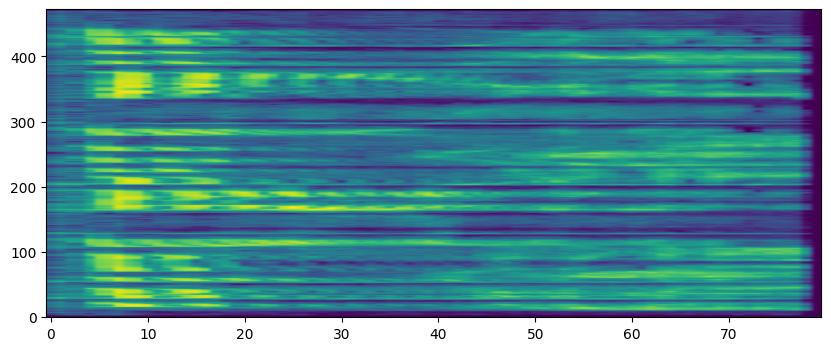

In [ ]:
# Draw spectrogram of ad[0][0]
plt.figure(figsize=(10, 4))
plt.imshow(test_ds[0][0].detach().numpy(), aspect="auto", origin="lower")

In [ ]:
class SpeechRecognitionModel(nn.Module):
    def __init__(self, vocabulary: list[str]):
        super().__init__()
        self.vocabulary = vocabulary
        self.conformer = Conformer(
            input_dim=N_MELS,
            num_heads=8,
            ffn_dim=N_FFT,
            num_layers=10,
            depthwise_conv_kernel_size=33,
        )
        self.fc = nn.Linear(N_MELS, len(vocabulary))
        
    def forward(self, x, lengths):
        x, lengths = self.conformer(x, lengths)
        x = self.fc(x).transpose(0, 1)
        return x, lengths

In [ ]:
class LightningModel(L.LightningModule):
    def __init__(self, vocabulary: list[str]):
        super().__init__()
        self.vocabulary = vocabulary
        self.model = SpeechRecognitionModel(vocabulary)
        self.criterion = nn.CTCLoss(blank=0, zero_infinity=True)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
    
    def forward(self, x, lengths):
        return self.model(x, lengths)
    
    def training_step(self, batch):
        mel_spec, labels, mel_spec_lengths, labels_lengths = batch
        logits, lengths = self(mel_spec, mel_spec_lengths)
        
        loss = self.criterion(logits.log_softmax(2), labels, lengths, labels_lengths)

        self.log("train_loss", loss, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch):
        mel_spec, labels, mel_spec_lengths, labels_lengths = batch
        logits, lengths = self(mel_spec, mel_spec_lengths)
        
        loss = self.criterion(logits.log_softmax(2), labels, lengths, labels_lengths)
        
        self.log("val_loss", loss, prog_bar=True)

        return loss
    
    def configure_optimizers(self):
        return self.optimizer

In [ ]:
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(dev_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

trainer = L.Trainer(
    max_epochs=1,
    accelerator="auto",
    enable_checkpointing=False,
    log_every_n_steps=1000,
)
lightning_model = LightningModel(VOCABULARY)

trainer.fit(lightning_model, train_dl, val_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | SpeechRecognitionModel | 1.8 M  | train
1 | criterion | CTCLoss                | 0      | train
-------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.075     Total estimated model params size (MB)
325       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\setday\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\setday\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\setday\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (784) is smaller than the logging interval Trainer(log_every_n_steps=1000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 12.18 GiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 12.30 GiB is allocated by PyTorch, and 105.56 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
val_dl = DataLoader(dev_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Validate
def validate(model, dataloader):
    model.eval()
    with torch.no_grad():
        for mel_spec, labels, mel_spec_lengths, labels_lengths in tqdm(dataloader, desc="Validating", unit="batch"):
            logits, lengths = model(mel_spec, mel_spec_lengths)
            logits = logits.log_softmax(2)
            preds = logits.argmax(2)
            
            for i in range(len(preds)):
                pred = tokens_to_number(preds[i][:lengths[i]])
                label = tokens_to_number(labels[i][:labels_lengths[i]])
                
                if Levenshtein.distance(pred, label) > 0:
                    # print(f"Pred: {pred}, Label: {label}")
                    break
            else:
                print("All predictions are correct!")
                break
validate(lightning_model, val_dl)